#  <font color='blue'> Hyperparameter optimization to determine appropriate no. of Neurons in a Single Hidden Layer Neural Network </font>

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

### Load the dataset

In [22]:
df = pd.read_excel('Concrete_Data.xls')
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


### Split the dataset into training, validation, and testing sets

In [5]:
# 60% train, 20% validation, 20% test

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=0)

### Normalize the datasets

In [6]:
train_df_norm = (train_df - train_df.mean()) / train_df.std()
val_df_norm   = (val_df - train_df.mean()) / train_df.std()
test_df_norm  = (test_df - train_df.mean()) / train_df.std()

### Convert the datasets to numpy arrays

In [7]:
train_data = train_df_norm.values
val_data   = val_df_norm.values
test_data  = test_df_norm.values

### Model

In [8]:
class NeuralNetwork:
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.weights1 = np.random.randn(input_dim, hidden_dim)
        self.bias1 = np.zeros((1, hidden_dim))
        self.weights2 = np.random.randn(hidden_dim, output_dim)
        self.bias2 = np.zeros((1, output_dim))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward(self, X):
        self.hidden_layer = self.sigmoid(np.dot(X, self.weights1) + self.bias1)
        self.output_layer = np.dot(self.hidden_layer, self.weights2) + self.bias2
        return self.output_layer
    
    def backward(self, X, y, learning_rate):
        d_output_layer = y - self.output_layer
        d_weights2 = np.dot(self.hidden_layer.T, d_output_layer)
        d_bias2 = np.sum(d_output_layer, axis=0, keepdims=True)
        d_hidden_layer = np.dot(d_output_layer, self.weights2.T) * self.sigmoid_derivative(self.hidden_layer)
        d_weights1 = np.dot(X.T, d_hidden_layer)
        d_bias1 = np.sum(d_hidden_layer, axis=0, keepdims=True)
        
        self.weights1 += learning_rate * d_weights1
        self.bias1 += learning_rate * d_bias1
        self.weights2 += learning_rate * d_weights2
        self.bias2 += learning_rate * d_bias2
    
    def train(self, X, y, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            for i in range(len(X)):
                xi = X[i].reshape(1, -1)
                yi = y[i].reshape(1, -1)
                output = self.forward(xi)
                self.backward(xi, yi, learning_rate)
    def predict(self, X):
        return self.forward(X)

### Define the input and output dimensions

In [9]:
input_dim = 8
output_dim = 1

### Finding the appropriate number of neurons

In [10]:
# Define the range of possible values for the number of neurons in the hidden layer
neuron_range = range(1, 5)

# Train and validate a neural network for each value of neurons in the range
best_mse = float('inf')
best_neuron = None
for n in neuron_range:
    # Define the neural network architecture
    hidden_dim = n
    model = NeuralNetwork(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

    # Train the neural network on the training set and validate on the validation set
    model.train(train_data[:, :input_dim], train_data[:, -1].reshape(-1, 1), num_epochs=1000, learning_rate=0.1)
    predictions = model.predict(val_data[:, :input_dim])
    mse = np.mean((predictions - val_data[:, -1].reshape(-1, 1)) ** 2)

    # Keep track of the best neural network based on validation set performance
    if mse < best_mse:
        best_mse = mse
        best_neuron = n

### Train the best neural network on the combined training and validation sets

In [11]:
model = NeuralNetwork(input_dim=input_dim, hidden_dim=best_neuron, output_dim=output_dim)
model.train(np.concatenate([train_data[:, :input_dim], val_data[:, :input_dim]]),
            np.concatenate([train_data[:, -1].reshape(-1, 1), val_data[:, -1].reshape(-1, 1)]),
            num_epochs=1000, learning_rate=0.1)

### Test the best neural network on the testing set

In [12]:
predictions = model.predict(test_data[:, :input_dim])
mse = np.mean((predictions - test_data[:, -1].reshape(-1, 1)) ** 2)
print('Best number of neurons:', best_neuron)
print('Mean Squared Error:', mse)

Best number of neurons: 4
Mean Squared Error: 0.15219889074985293


#  <font color='blue'> Comparing this Optimal Single Layer Neural Network with Linear and Quadratic Regression :</font>

### Importing LinearRegression Model from SkLearn. And spliting the data into train (80%) and test (20%) and normalizing.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
df_norm = (df - df.mean()) / df.std()
X=df_norm.drop('Concrete compressive strength(MPa, megapascals) ',axis=1)
y=df_norm['Concrete compressive strength(MPa, megapascals) ']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

LinearRegression()

### Linear regression model

In [ ]:
linear_model=LinearRegression()
linear_model.fit(train_X,train_y)

###  Quadratic regression model

In [14]:
# Generating polynomial features 
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=2)
quadratic_X_train=poly.fit_transform(train_X)
quadratic_X_test=poly.transform(test_X)

quadratic_model=LinearRegression()
quadratic_model.fit(quadratic_X_train,train_y)

LinearRegression()

### Computing "Mean Squared Error" for all the models

In [15]:
# Compute the MSE for linear regression
linear_predictions = linear_model.predict(test_X)
linear_mse = np.mean((linear_predictions - test_y) ** 2)

# Compute the MSE for quadratic regression
quadratic_predictions = quadratic_model.predict(quadratic_X_test)
quadratic_mse = np.mean((quadratic_predictions - test_y) ** 2)

# Compute the MSE for the optimal neural network
nn_predictions = model.predict(test_data[:, :input_dim])
nn_mse = np.mean((predictions - test_data[:, -1].reshape(-1, 1)) ** 2)

In [16]:
print("MSE using Linear Regression:\t",linear_mse)
print("="*80)
print("MSE using Quadratic Regression:\t",quadratic_mse)
print("="*80)
print("MSE using Optimal Neural Network:\t",nn_mse)

MSE using Linear Regression:	 0.3438998917242788
MSE using Quadratic Regression:	 0.19919013475199904
MSE using Optimal Neural Network:	 0.15219889074985293


### Compute " r<sup>2</sup> " score

In [19]:
from sklearn.metrics import r2_score

# Compute the R2 error for linear regression
linear_r2 = r2_score(test_y, linear_predictions)

# Compute the R2 error for quadratic regression
quadratic_r2 = r2_score(test_y, quadratic_predictions)

# Compute the R2 error for the neural network
nn_r2 = r2_score(test_data[:, -1], nn_predictions)


In [20]:
print("r2_score using Linear Regression:\t",linear_r2)
print("="*80)
print("r2_score using Quadratic Regression:\t",quadratic_r2)
print("="*80)
print("r2_score using Optimal Neural Network:\t",nn_r2)

r2_score using Linear Regression:	 0.627541605542902
r2_score using Quadratic Regression:	 0.7842685049726497
r2_score using Optimal Neural Network:	 0.8377960159207484


 * A higher R2 score is generally considered better in the context of regression models. The R2 score, also known as the coefficient of determination, measures the proportion  of the variance in the dependent variable that can be explained by the independent variables.

### Plotting results for  <font color='red'>Linear Regression</font>  , <font color='blue'>Quadratic Regression</font> and <font color='green'>Neural Network</font>

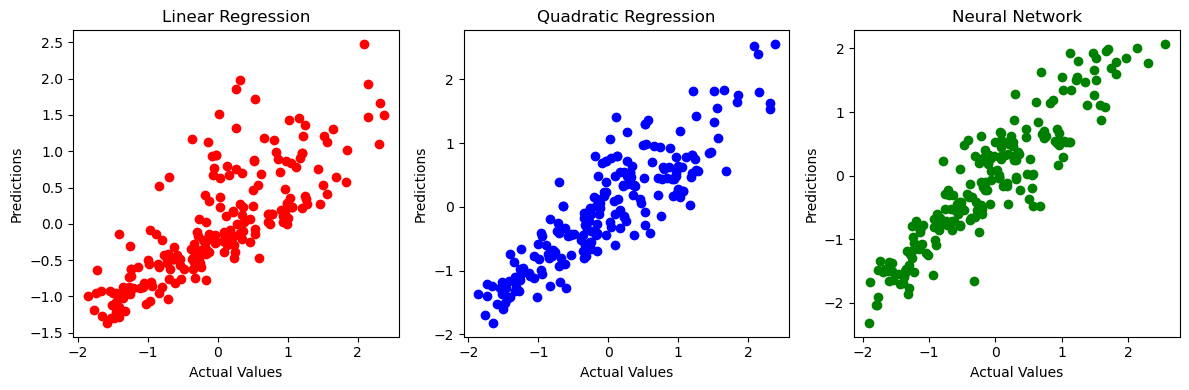

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plot the predictions and actual values for linear regression
axes[0].scatter(test_y, linear_predictions,color='red')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predictions')
axes[0].set_title('Linear Regression')

# Plot the predictions and actual values for quadratic regression
axes[1].scatter(test_y, quadratic_predictions,color='blue')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predictions')
axes[1].set_title('Quadratic Regression')

# Plot the predictions and actual values for the optimal neural network
axes[2].scatter(test_data[:, -1].reshape(-1, 1), nn_predictions,color='green')
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predictions')
axes[2].set_title('Neural Network')

plt.tight_layout()
plt.show()
